In [97]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [227]:
def show_image(image):
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    
def MLoG(img, kernelSize):
    #Laplace of Gaussian
    gaussianImg = cv2.GaussianBlur(img, (kernelSize, kernelSize), 0, 0)
    laplaceImg = cv2.Laplacian(gaussianImg, cv2.CV_16S)
    laplaceImg[laplaceImg < 0] = 0
    laplaceImg = cv2.convertScaleAbs(laplaceImg)
    
    ret,threshold_img = cv2.threshold(laplaceImg, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #binarize otsu
    return threshold_img

def CCC(img, kernelSize):
    #Connected Component Criteria
    #KernelSize Can only be odd numbers
    
    mlog1 = MLoG(img, kernelSize)
    mlog2 = MLoG(img, kernelSize-2)
    #Ilog laplace of gaussian

    #Number of connected Components NCC
    ncc1, _ = cv2.connectedComponents(mlog1)
    ncc2, _ = cv2.connectedComponents(mlog2)

    return (1 - (ncc1 / ncc2))

def STC(img, kernelSize):
    #Stop Criteria
    #KernelSize can only be odd numbers
    
    mlog1 = MLoG(img, kernelSize)
    mlog2 = MLoG(img, kernelSize - 2)
    mlog3 = MLoG(img, 1)
    
    ncc1, _ = cv2.connectedComponents(mlog1)
    ncc2, _ = cv2.connectedComponents(mlog2)
    ncc3, _ = cv2.connectedComponents(mlog3)
    return ((ncc1/ncc3) * np.abs(ncc2 - ncc1))

def ScreenToneRemoval(img, stcThreshold=1, beta=0.8):
    '''
    Return: remoovalMask, iLog, ibase
    '''
    maxCCC = 0
    iLog = 1
    i = 3
    while STC(img, i) > stcThreshold:
        if (CCC(img, i) > (beta * maxCCC)):
            iLog = i
            print("i: ",iLog)
            maxCCC = max(maxCCC, CCC(img, i))
            
        i = i + 2
        
    iLog = iLog + 4 #ilog
    
    if (int(i/2))%2 == 0:
        ibase = min(int(i/2) + 1, iLog)
    else:
        ibase = min(int(i/2), iLog)
        
    M_logI = MLoG(img, iLog)
    M_logBase = MLoG(img, ibase)
    Mask = cv2.bitwise_and(M_logI, M_logBase)
    
    return iLog, ibase, Mask

def DifferenceOfGaussian(img, kernelSize):
    firstGaussian = cv2.GaussianBlur(img, (kernelSize, kernelSize), 0, 0)
    secondGaussian = cv2.GaussianBlur(img, (kernelSize-2, kernelSize-2), 0, 0)
    
    return secondGaussian - firstGaussian



In [10]:
sample_image = cv2.imread("IMAGES/naruto.jpg", cv2.IMREAD_GRAYSCALE)

(500, 500, 3)

In [171]:
original_image = cv2.imread("fire-force2.png")
# original_image = cv2.resize(sample_image, (500,500))

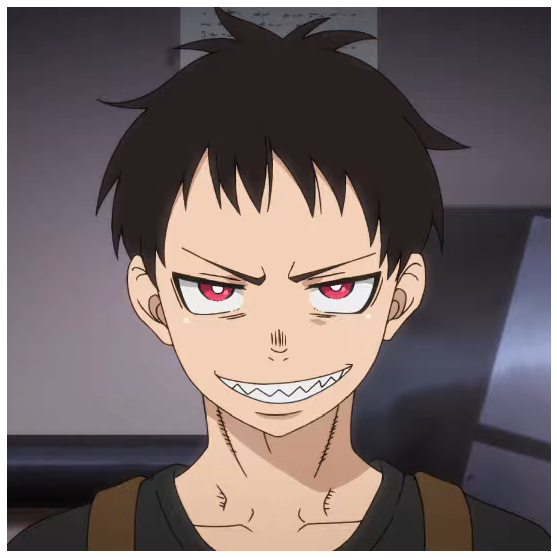

In [172]:
show_image(original_image)

In [173]:
bw_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

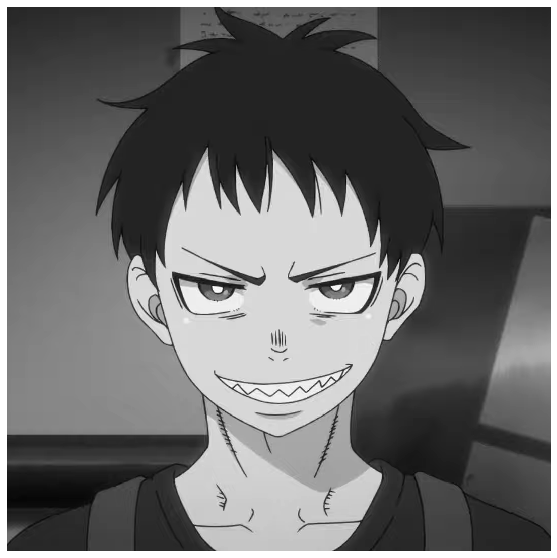

In [174]:
show_image(bw_image)

In [277]:
bw_image.shape

(1080, 1080)

Applying a Gaussian blur to the
images before removing the screentones produced better results
to a certain extent. As seen in Fig. 5, Gaussian blur with a kernel
radius of 1 or 2 gave improved results, while at a kernel radius of 3
the outlines started disappearing, reducing the quality of the result.
We can see that there is an optimal value, and our experiments
show that it depends on the input image. We therefore make this
setting available for adjustment by the use

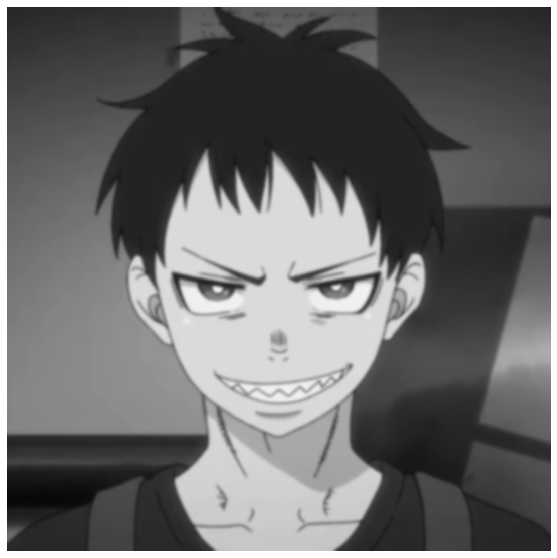

In [267]:
#First Step Gaussian Blur
GB_image = cv2.GaussianBlur(bw_image, (17,17), 0, 0)
show_image(GB_image)

In [ ]:

% channel - R
counterr = zeros(max(L(:))+1, 1);
fillerr = zeros(max(L(:))+1, 1);
fillerr = double(fillerr);

% channel - G
counterg = zeros(max(L(:))+1, 1);
fillerg = zeros(max(L(:))+1, 1);
fillerg = double(fillerg);

% channel - B
counterb =zeros(max(L(:))+1, 1);
fillerb = zeros(max(L(:))+1, 1);
fillerb = double(fillerb);
filler = zeros(max(L(:))+1, 3);

## Screentone Removal

First, we create
a screentone removal mask Mrm, which removes screentone
areas as much as possible, and a line preserving mask Ml p,
which retains as many lines as possible. Then, we combine
these masks, taking account of connected components



To select i, we
introduce two criteria, the Connected Component Criteria
(CCC) and the Stop Criteria (STC), which are defined as
follows

CCCi = 1−
NCC(MLoGi
)
NCC(MLoGi−2
)
, (3)
STCi =
NCC(MLoGi
)
NCC(MLoG1
)
×|(NCC(MLoGi−2
)−NCC(MLoGi
))|

where NCC(M) is the number of connected components of
black pixels in a mask M. CCCi
is a ratio showing the decrease in the number of connected components when i is incremented. If CCCi has its highest value at i
∗
, it means the
most screentones are removed at i
∗
. We empirically found
that i values a little larger than i
∗
are best for our purpose.
If we increment i much more, the lines become too blurred

i:  3
i:  15


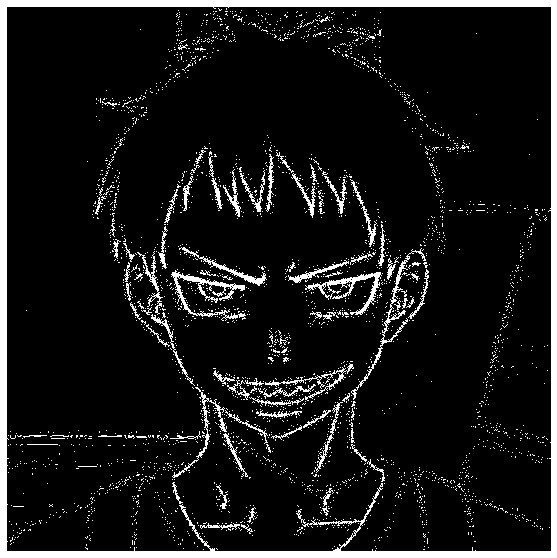

In [274]:
# Screen Tone Removal
ilog, ibase, removalMask = ScreenToneRemoval(GB_image)
# Line Preserving
linePreservingMask = DifferenceOfGaussian(GB_image, 7)
#
mask = cv2.bitwise_or(removalMask, removalMask, mask=linePreservingMask) #or
n, components = cv2.connectedComponents(mask, connectivity=8)
R = removalMask
show_image(mask)

In [105]:
# show_image(sample_image)
# show_image(mask)
# show_image(removalMask)
# show_image(linePreservingMask)

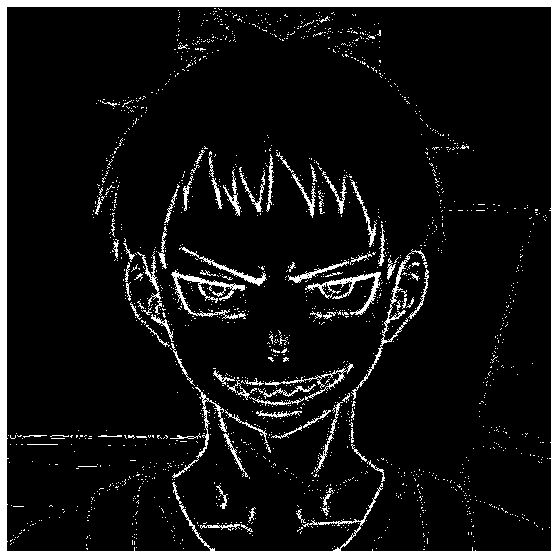

In [275]:
L = np.zeros(bw_image.shape,  np.uint8)
for label in range(1, n):
    mask = np.array(components, dtype=np.uint8)
    if len(mask[components == label]) > 1:
        mask[components == label] = 255
        mask[mask < 255] = 0
        intersection = cv2.bitwise_and(R, mask)
        L = cv2.bitwise_or(L, mask)
    '''
    
    show_image(intersection)
    show_image(mask)
        
    
    show_image(L)
    '''
show_image(L)

    #bitwise OR

In [253]:
result = cv2.bitwise_not(L)

fills = []

fill = trapped_ball_fill_multi(result, 5, method="mean")
fills += fill
result = mark_fill(result, fill)

# for i in range(4, 1, -1):
#     fill = trapped_ball_fill_multi(result, i, method=None)
#     fills += fill
#     result = mark_fill(result, fill)

fill = flood_fill_multi(result)
fills += fill

fillmap = build_fill_map(result, fills)


trapped-ball 5
floodfill


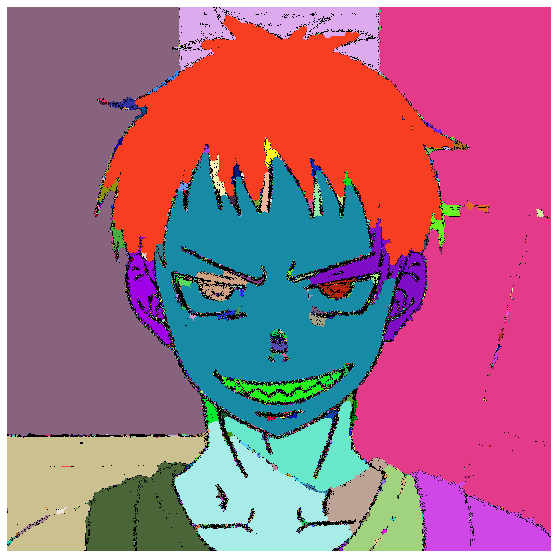

In [254]:
show_image(np.array(show_fill_map(fillmap), dtype=np.uint8))

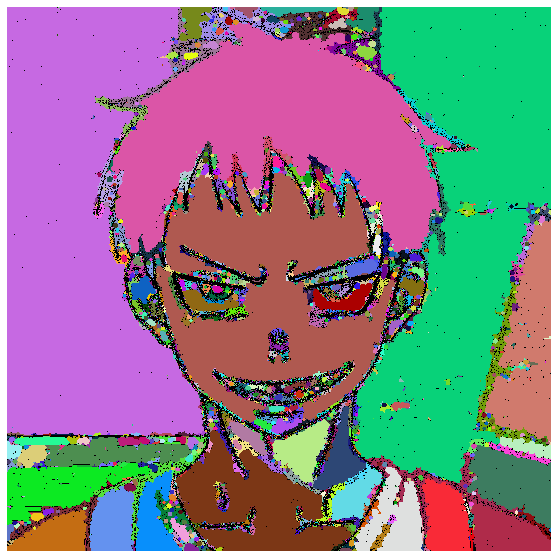

In [134]:
show_image(np.array(show_fill_map(fillmap), dtype=np.uint8))

In [120]:
cv2.imwrite('fills.png', np.array(show_fill_map(fillmap), dtype=np.uint8))

True

In [60]:
fillmap.shape

(571, 665)

In [94]:
np.zeros
for i in range(1000):
    mask = fillmap
    print(fillmap[fillmap == i])
    mask
    if mask == []:
        break

[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[3 3 3 ... 3 3 3]
[4 4 4 ... 4 4 4]
[5 5 5 ... 5 5 5]
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6]
[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
[8 8 8 8 

C:\Users\ryan_\.conda\envs\azure_grabchallenge\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


[333]
[334]
[335]
[336 336 336 336 336 336]
[337]
[338 338 338]
[339]
[340 340]
[341]
[342 342]
[343]
[344]
[345 345 345]
[346]
[347 347 347 347 347]
[348]
[349]
[350]
[351 351]
[352]
[353 353 353 353 353 353 353 353 353 353]
[354]
[355]
[356 356]
[357 357 357 357 357 357 357]
[358 358 358 358]
[359 359]
[360]
[361]
[362]
[363]
[364 364]
[365 365]
[366]
[367 367]
[368]
[369]
[370]
[371 371 371]
[372]
[373 373 373 373 373 373]
[374]
[375 375]
[376]
[377]
[378 378]
[379 379]
[380]
[381]
[382]
[383]
[384 384 384]
[385 385 385]
[386]
[387]
[388 388 388 388]
[389]
[390]
[391]
[392 392]
[393]
[394 394 394 394 394]
[395 395 395]
[396 396]
[397]
[398 398]
[399 399 399]
[400]
[401 401 401 401 401]
[402]
[403 403 403 403]
[404]
[405]
[406 406 406 406 406 406 406 406 406 406 406 406 406 406]
[407 407 407 407 407 407 407 407 407 407 407 407 407 407 407 407 407 407
 407 407 407 407 407 407 407 407 407 407]
[408]
[409 409 409 409]
[410 410]
[411]
[412 412 412 412]
[413 413]
[414]
[415 415]
[416]
[41

In [ ]:
import numpy as np

data = np.genfromtxt('data')
data[data == 0] = np.nan
means = np.nanmean(data[:, 1:], axis=1)

In [78]:
fillmap[fillmap != 1] = 0

In [ ]:
sample_image

In [81]:
fillmap.shape

(571, 665)

In [ ]:
for label in range(1, n):
    mask = np.array(components, dtype=np.uint8)
    mask[components == label] = 255

In [83]:
sample_image.shape

(571, 665)

In [85]:
test=cv2.bitwise_and(sample_image, np.array(fillmap, dtype=np.uint8))

In [87]:
test[test == 1] = 255

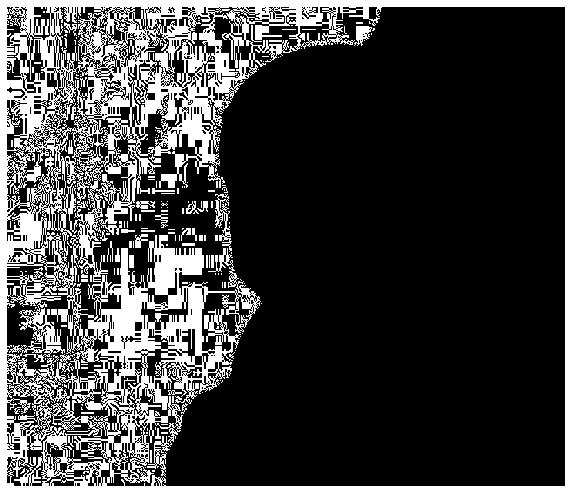

In [88]:
show_image(test)

In [64]:
fillmap.shape

(571, 665)

In [ ]:
def show_fill_map(fillmap):
    """Mark filled areas with colors. It is useful for visualization.
    # Arguments
        image: an image.
        fills: an array of fills' points.
    # Returns
        an image.
    """
    # Generate color for each fill randomly.
    colors = np.random.randint(0, 255, (np.max(fillmap) + 1, 3))
    # Id of line is 0, and its color is black.
    colors[0] = [0, 0, 0]

    return colors[fillmap]


In [53]:
import numpy as np

#create a 2x2x3 image with ones
img = np.ones( (5,5) )



In [ ]:
#make the off diagonal pixels into zeros
img[0,1] = [0,0,0]
img[1,0] = [0,0,0]

#find the only zeros pixels with the mask 
#(of course any other color combination would work just as well)
#... and apply "all" along the color axis
mask = (img == [0.,0.,0.]).all(axis=2)

#apply the mask to overwrite the pixels
img[ mask ] = [255,0,0]

In [51]:
img[0,1]

array([1., 1., 1.])

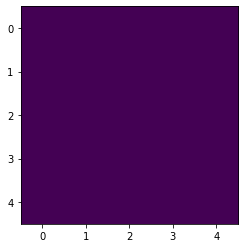

In [54]:
plt.imshow(img)

In [38]:
color=np.random.randint(0, 255, (np.max(fillmap) + 1, 3))

In [40]:
color.shape

(945, 3)

In [42]:
color[0]=[0,0,0]

In [44]:
color.shape

(945, 3)

True

In [30]:
show_fill_map(fillmap)

array([[[109, 219,  65],
        [109, 219,  65],
        [109, 219,  65],
        ...,
        [136, 237, 138],
        [136, 237, 138],
        [136, 237, 138]],

       [[109, 219,  65],
        [109, 219,  65],
        [109, 219,  65],
        ...,
        [136, 237, 138],
        [136, 237, 138],
        [136, 237, 138]],

       [[109, 219,  65],
        [109, 219,  65],
        [109, 219,  65],
        ...,
        [136, 237, 138],
        [136, 237, 138],
        [136, 237, 138]],

       ...,

       [[109, 219,  65],
        [109, 219,  65],
        [109, 219,  65],
        ...,
        [108, 147,  53],
        [108, 147,  53],
        [108, 147,  53]],

       [[109, 219,  65],
        [109, 219,  65],
        [109, 219,  65],
        ...,
        [108, 147,  53],
        [108, 147,  53],
        [108, 147,  53]],

       [[109, 219,  65],
        [109, 219,  65],
        [109, 219,  65],
        ...,
        [108, 147,  53],
        [108, 147,  53],
        [108, 147,  53]]

In [26]:
fillmap.shape

(571, 665)

In [27]:
mask.shape

(571, 665)

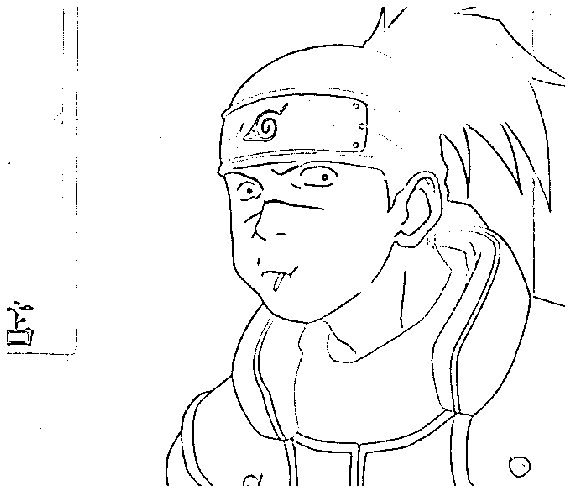

In [21]:
show_image(cv2.bitwise_not(mask))

In [ ]:
trapped_ball_fill_multi

In [19]:
def get_ball_structuring_element(radius):
    """Get a ball shape structuring element with specific radius for morphology operation.
    The radius of ball usually equals to (leaking_gap_size / 2).
    
    # Arguments
        radius: radius of ball shape.
             
    # Returns
        an array of ball structuring element.
    """
    return cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * radius + 1, 2 * radius + 1))


def get_unfilled_point(image):
    """Get points belong to unfilled(value==255) area.
    # Arguments
        image: an image.
    # Returns
        an array of points.
    """
    y, x = np.where(image == 255)

    return np.stack((x.astype(int), y.astype(int)), axis=-1)


def exclude_area(image, radius):
    """Perform erosion on image to exclude points near the boundary.
    We want to pick part using floodfill from the seed point after dilation. 
    When the seed point is near boundary, it might not stay in the fill, and would
    not be a valid point for next floodfill operation. So we ignore these points with erosion.
    # Arguments
        image: an image.
        radius: radius of ball shape.
    # Returns
        an image after dilation.
    """
    return cv2.morphologyEx(image, cv2.MORPH_ERODE, get_ball_structuring_element(radius), anchor=(-1, -1), iterations=1)


def trapped_ball_fill_single(image, seed_point, radius):
    """Perform a single trapped ball fill operation.
    # Arguments
        image: an image. the image should consist of white background, black lines and black fills.
               the white area is unfilled area, and the black area is filled area.
        seed_point: seed point for trapped-ball fill, a tuple (integer, integer).
        radius: radius of ball shape.
    # Returns
        an image after filling.
    """
    ball = get_ball_structuring_element(radius)

    pass1 = np.full(image.shape, 255, np.uint8)
    pass2 = np.full(image.shape, 255, np.uint8)

    im_inv = cv2.bitwise_not(image)

    # Floodfill the image
    mask1 = cv2.copyMakeBorder(im_inv, 1, 1, 1, 1, cv2.BORDER_CONSTANT, 0)
    _, pass1, _, _ = cv2.floodFill(pass1, mask1, seed_point, 0, 0, 0, 4)

    # Perform dilation on image. The fill areas between gaps became disconnected.
    pass1 = cv2.morphologyEx(pass1, cv2.MORPH_DILATE, ball, anchor=(-1, -1), iterations=1)
    mask2 = cv2.copyMakeBorder(pass1, 1, 1, 1, 1, cv2.BORDER_CONSTANT, 0)

    # Floodfill with seed point again to select one fill area.
    _, pass2, _, rect = cv2.floodFill(pass2, mask2, seed_point, 0, 0, 0, 4)
    # Perform erosion on the fill result leaking-proof fill.
    pass2 = cv2.morphologyEx(pass2, cv2.MORPH_ERODE, ball, anchor=(-1, -1), iterations=1)

    return pass2


def trapped_ball_fill_multi(image, radius, method='mean', max_iter=1000):
    """Perform multi trapped ball fill operations until all valid areas are filled.
    # Arguments
        image: an image. The image should consist of white background, black lines and black fills.
               the white area is unfilled area, and the black area is filled area.
        radius: radius of ball shape.
        method: method for filtering the fills. 
               'max' is usually with large radius for select large area such as background.
        max_iter: max iteration number.
    # Returns
        an array of fills' points.
    """
    print('trapped-ball ' + str(radius))

    unfill_area = image
    filled_area, filled_area_size, result = [], [], []

    for _ in range(max_iter):
        points = get_unfilled_point(exclude_area(unfill_area, radius))

        if not len(points) > 0:
            break

        fill = trapped_ball_fill_single(unfill_area, (points[0][0], points[0][1]), radius)
        unfill_area = cv2.bitwise_and(unfill_area, fill)

        filled_area.append(np.where(fill == 0))
        filled_area_size.append(len(np.where(fill == 0)[0]))

    filled_area_size = np.asarray(filled_area_size)

    if method == 'max':
        area_size_filter = np.max(filled_area_size)
    elif method == 'median':
        area_size_filter = np.median(filled_area_size)
    elif method == 'mean':
        area_size_filter = np.mean(filled_area_size)
    else:
        area_size_filter = 0

    result_idx = np.where(filled_area_size >= area_size_filter)[0]

    for i in result_idx:
        result.append(filled_area[i])

    return result


def flood_fill_single(im, seed_point):
    """Perform a single flood fill operation.
    # Arguments
        image: an image. the image should consist of white background, black lines and black fills.
               the white area is unfilled area, and the black area is filled area.
        seed_point: seed point for trapped-ball fill, a tuple (integer, integer).
    # Returns
        an image after filling.
    """
    pass1 = np.full(im.shape, 255, np.uint8)

    im_inv = cv2.bitwise_not(im)

    mask1 = cv2.copyMakeBorder(im_inv, 1, 1, 1, 1, cv2.BORDER_CONSTANT, 0)
    _, pass1, _, _ = cv2.floodFill(pass1, mask1, seed_point, 0, 0, 0, 4)

    return pass1


def flood_fill_multi(image, max_iter=20000):
    """Perform multi flood fill operations until all valid areas are filled.
    This operation will fill all rest areas, which may result large amount of fills.
    # Arguments
        image: an image. the image should contain white background, black lines and black fills.
               the white area is unfilled area, and the black area is filled area.
        max_iter: max iteration number.
    # Returns
        an array of fills' points.
    """
    print('floodfill')

    unfill_area = image
    filled_area = []

    for _ in range(max_iter):
        points = get_unfilled_point(unfill_area)

        if not len(points) > 0:
            break

        fill = flood_fill_single(unfill_area, (points[0][0], points[0][1]))
        unfill_area = cv2.bitwise_and(unfill_area, fill)

        filled_area.append(np.where(fill == 0))

    return filled_area


def mark_fill(image, fills):
    """Mark filled areas with 0.
    # Arguments
        image: an image.
        fills: an array of fills' points.
    # Returns
        an image.
    """
    result = image.copy()

    for fill in fills:
        result[fill] = 0

    return result


def build_fill_map(image, fills):
    """Make an image(array) with each pixel(element) marked with fills' id. id of line is 0.
    # Arguments
        image: an image.
        fills: an array of fills' points.
    # Returns
        an array.
    """
    result = np.zeros(image.shape[:2], np.int)

    for index, fill in enumerate(fills):
        result[fill] = index + 1

    return result


def show_fill_map(fillmap):
    """Mark filled areas with colors. It is useful for visualization.
    # Arguments
        image: an image.
        fills: an array of fills' points.
    # Returns
        an image.
    """
    # Generate color for each fill randomly.
    colors = np.random.randint(0, 255, (np.max(fillmap) + 1, 3))
    # Id of line is 0, and its color is black.
    colors[0] = [0, 0, 0]

    return colors[fillmap]


def get_bounding_rect(points):
    """Get a bounding rect of points.
    # Arguments
        points: array of points.
    # Returns
        rect coord
    """
    x1, y1, x2, y2 = np.min(points[1]), np.min(points[0]), np.max(points[1]), np.max(points[0])
    return x1, y1, x2, y2


def get_border_bounding_rect(h, w, p1, p2, r):
    """Get a valid bounding rect in the image with border of specific size.
    # Arguments
        h: image max height.
        w: image max width.
        p1: start point of rect.
        p2: end point of rect.
        r: border radius.
    # Returns
        rect coord
    """
    x1, y1, x2, y2 = p1[0], p1[1], p2[0], p2[1]

    x1 = x1 - r if 0 < x1 - r else 0
    y1 = y1 - r if 0 < y1 - r else 0
    x2 = x2 + r + 1 if x2 + r + 1 < w else w
    y2 = y2 + r + 1 if y2 + r + 1 < h else h

    return x1, y1, x2, y2


def get_border_point(points, rect, max_height, max_width):
    """Get border points of a fill area
    # Arguments
        points: points of fill .
        rect: bounding rect of fill.
        max_height: image max height.
        max_width: image max width.
    # Returns
        points , convex shape of points
    """
    # Get a local bounding rect.
    border_rect = get_border_bounding_rect(max_height, max_width, rect[:2], rect[2:], 2)

    # Get fill in rect.
    fill = np.zeros((border_rect[3] - border_rect[1], border_rect[2] - border_rect[0]), np.uint8)
    # Move points to the rect.
    fill[(points[0] - border_rect[1], points[1] - border_rect[0])] = 255

    # Get shape.
    _, contours, _ = cv2.findContours(fill, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    approx_shape = cv2.approxPolyDP(contours[0], 0.02 * cv2.arcLength(contours[0], True), True)

    # Get border pixel.
    # Structuring element in cross shape is used instead of box to get 4-connected border.
    cross = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    border_pixel_mask = cv2.morphologyEx(fill, cv2.MORPH_DILATE, cross, anchor=(-1, -1), iterations=1) - fill
    border_pixel_points = np.where(border_pixel_mask == 255)

    # Transform points back to fillmap.
    border_pixel_points = (border_pixel_points[0] + border_rect[1], border_pixel_points[1] + border_rect[0])

    return border_pixel_points, approx_shape


def merge_fill(fillmap, max_iter=10):
    """Merge fill areas.
    # Arguments
        fillmap: an image.
        max_iter: max iteration number.
    # Returns
        an image.
    """
    max_height, max_width = fillmap.shape[:2]
    result = fillmap.copy()

    for i in range(max_iter):
        print('merge ' + str(i + 1))

        result[np.where(fillmap == 0)] = 0

        fill_id = np.unique(result.flatten())
        fills = []

        for j in fill_id:
            point = np.where(result == j)

            fills.append({
                'id': j,
                'point': point,
                'area': len(point[0]),
                'rect': get_bounding_rect(point)
            })

        for j, f in enumerate(fills):
            # ignore lines
            if f['id'] == 0:
                continue

            border_points, approx_shape = get_border_point(f['point'], f['rect'], max_height, max_width)
            border_pixels = result[border_points]
            pixel_ids, counts = np.unique(border_pixels, return_counts=True)

            ids = pixel_ids[np.nonzero(pixel_ids)]
            new_id = f['id']
            if len(ids) == 0:
                # points with lines around color change to line color
                # regions surrounded by line remain the same
                if f['area'] < 5:
                    new_id = 0
            else:
                # region id may be set to region with largest contact
                new_id = ids[0]

            # a point
            if len(approx_shape) == 1 or f['area'] == 1:
                result[f['point']] = new_id

            #
            if len(approx_shape) in [2, 3, 4, 5] and f['area'] < 500:
                result[f['point']] = new_id

            if f['area'] < 250 and len(ids) == 1:
                result[f['point']] = new_id

            if f['area'] < 50:
                result[f['point']] = new_id

        if len(fill_id) == len(np.unique(result.flatten())):
            break

    return result

In [103]:
cartoon_image = cv2.edgePreservingFilter(sample_image, flags=1, sigma_s=60, sigma_r=0.4)

In [ ]:
# Screen Tone Removal
ilog, ibase, removalMask = ScreenToneRemoval()
# Line Preserving
linePreservingMask = DifferenceOfGaussian(sample_image, 5)
#
mask = cv2.bitwise_and(removalMask, removalMask, mask=linePreservingMask) #or
n, components = cv2.connectedComponents(mask)
R = removalMask
show_image(mask)